[nltk_data] Downloading package punkt to /home/alex/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

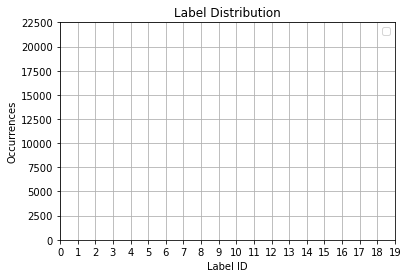

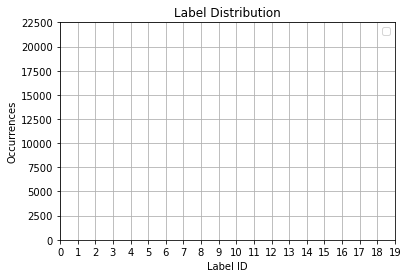

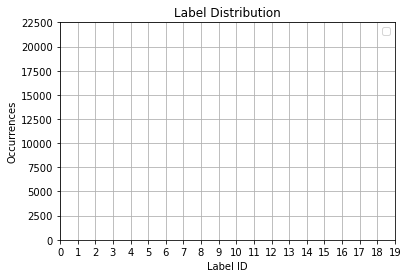

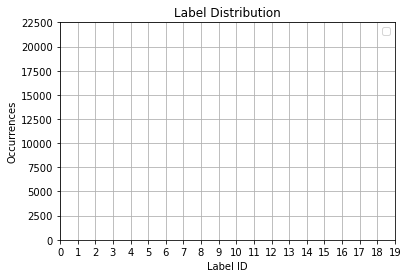

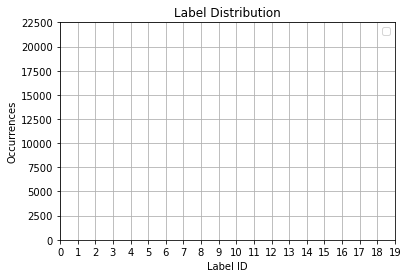

In [45]:
import os.path
import re
from collections.abc import Iterable
from io import StringIO

import pandas as pd
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import nltk
nltk.download('punkt')

In [2]:
# Modified dataset
class ImageCaptionDataset(Dataset):
    """Class for dataset interaction, designed for use with PyTorch."""

    TIERS = ('train', 'test')
    CLASSES = tuple(range(20))

    def __init__(
            self,
            path,
            tier,
            embeddings=None,
            preprocessor=None,
            transform=None):
        """Create a new dataset instance that loads images and captions from \
        the provided path for the given tier."""
        super().__init__()
        assert os.path.isdir(path)
        assert os.path.exists(os.path.join(path, f'{tier}.csv'))
        assert tier in self.TIERS

        self.path = path
        self.tier = tier
        self.data = None
        self.embeddings = embeddings
        self.preprocessor = preprocessor
        self.transform = transform
        self._init_dataset()

    def _init_dataset(self):
        # Load captions and add escape chars to aid parsing.
        with open(os.path.join(self.path, f'{self.tier}.csv')) as file:
            lines = [re.sub(
                r'([^,])"(\s*[^\n])',
                r'\1`"\2',
                line
            ) for line in file]
            self.data = pd.read_csv(
                StringIO(''.join(lines)),
                escapechar='`'
            )

        # Preprocess captions
        caption_col = self.data.columns[-1]
        if self.preprocessor is not None:
            self.data[caption_col] = self.data[caption_col].apply(
                self.preprocessor
            )

        # Preprocess labels
        if self.tier != self.TIERS[-1]:
            lbl_col = self.data.columns[1]
            self.data[lbl_col] = self.data[lbl_col].apply(
                lambda lbls: [int(lbl) for lbl in lbls.split()]
            )

    def __getitem__(self, key):
        """Get an item from the dataset for a given index.

        Note that the index may not strictly correspond with the image id for \
        the returned record; e.g. if `tier = 'test'`, then index 0 refers to \
        image id 30000.
        """
        # Get images and apply transforms
        image_file = self.data[self.data.columns[0]][key]
        image = Image.open(os.path.join(self.path, 'data', image_file))

        # Get caption embeddings
        caption = self.data[self.data.columns[-1]][key]

        if self.tier != self.TIERS[-1]:
            labels = self.data[self.data.columns[1]][key]
            return image_file, image, caption, labels

        return image_file, image, caption

    def __len__(self):
        """Return the length of the dataset."""
        return len(self.data)


In [3]:
def preprocess(sentence):
    words = nltk.word_tokenize(sentence)
    words = [re.sub(r'[^\w\s\']', r'', w) for w in words]
    return words

In [4]:
data_path = '../input'

train_data = ImageCaptionDataset(data_path, 'train', preprocessor=preprocess)
test_data = ImageCaptionDataset(data_path, 'test', preprocessor=preprocess)

In [122]:
lbl_dist = [0 for i in range(len(ImageCaptionDataset.CLASSES))]
lbl_count_dist = [0 for i in range(len(ImageCaptionDataset.CLASSES) + 1)]
for idx in range(len(train_data)):
    image_file, image, caption, labels = train_data[idx]
    lbl_count_dist[len(labels)] += 1
    for lbl in labels:
        lbl_dist[lbl] += 1
print(lbl_dist)
print(lbl_count_dist)

[0, 22797, 1164, 4365, 1272, 1132, 1395, 1221, 2210, 1042, 1471, 604, 0, 605, 252, 1934, 1099, 1430, 1525, 1020]
[0, 19377, 6651, 2563, 978, 339, 81, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


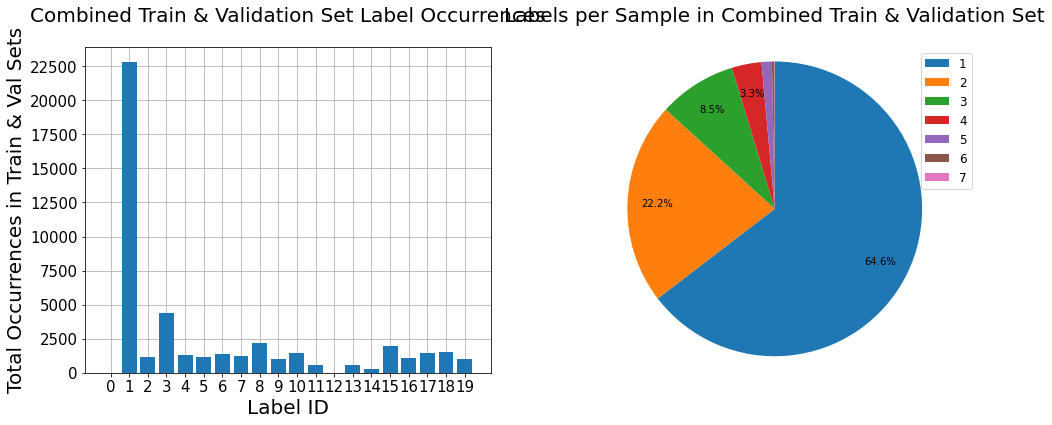

In [127]:
# Plot label count distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
x = [i for i in range(len(lbl_dist))]
y = lbl_dist
ax1.grid(zorder=0)
ax1.set_title('Combined Train & Validation Set Label Occurrences')
ax1.set_xlabel('Label ID')
ax1.set_ylabel('Total Occurrences in Train & Val Sets')
ax1.set_xticks([i for i in range(len(lbl_dist))])
ax1.set_yticks([i for i in range(0, max(lbl_dist), 2500)])
ax1.bar(x, y, zorder=2)

vals = lbl_count_dist
vals = {i: v for i, v in enumerate(vals) if v != 0}
lbls = list(vals.keys())
ax2.set_title('Unique Labels per Sample in Combined Train & Validation Set')
ax2.pie(list(vals.values()), labels=lbls, autopct=lambda x: '{:1.1f}%'.format(x) if x > 2 else '', startangle=90, counterclock=False, labeldistance=None, pctdistance=0.8)
ax2.axis('equal')
ax2.legend()
plt.savefig('./img/label_counts.png')
plt.show()


In [124]:
train_lbl_dist = [0 for i in range(len(ImageCaptionDataset.CLASSES))]
train_lbl_count_dist = [0 for i in range(len(ImageCaptionDataset.CLASSES) + 1)]
for idx in range(int(0.9*len(train_data))):
    image_file, image, caption, labels = train_data[idx]
    train_lbl_count_dist[len(labels)] += 1
    for lbl in labels:
        train_lbl_dist[lbl] += 1

print('Train')
print(train_lbl_dist)
print(train_lbl_count_dist)
print(sum(train_lbl_dist))
print(sum(train_lbl_count_dist))
val_lbl_dist = [0 for i in range(len(ImageCaptionDataset.CLASSES))]
val_lbl_count_dist = [0 for i in range(len(ImageCaptionDataset.CLASSES) + 1)]
for idx in range(int(0.9*len(train_data)), len(train_data)):
    image_file, image, caption, labels = train_data[idx]
    val_lbl_count_dist[len(labels)] += 1
    for lbl in labels:
        val_lbl_dist[lbl] += 1

print('Validation')
print(val_lbl_dist)
print(val_lbl_count_dist)
print(sum(val_lbl_dist))
print(sum(val_lbl_count_dist))


Train
[0, 20522, 1029, 3913, 1145, 1013, 1250, 1102, 1990, 933, 1305, 542, 0, 535, 219, 1718, 979, 1283, 1368, 922]
[0, 17499, 5960, 2293, 864, 300, 74, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
41768
27000
Validation
[0, 2275, 135, 452, 127, 119, 145, 119, 220, 109, 166, 62, 0, 70, 33, 216, 120, 147, 157, 98]
[0, 1878, 691, 270, 114, 39, 7, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
4770
3000


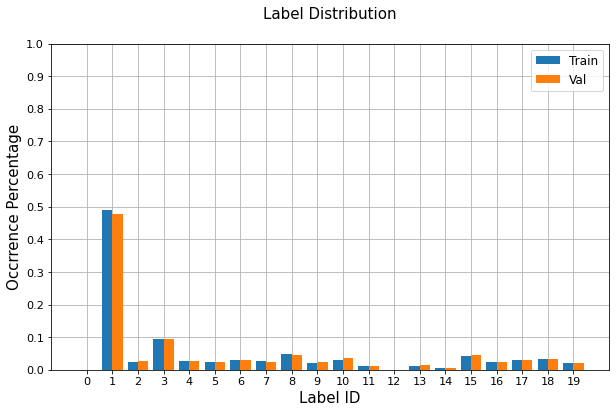

In [125]:
# Plot label count distribution
fig, ax = plt.subplots(figsize=(10,6))

ax.grid(zorder=0)
ax.set_title('Label Distribution')
ax.set_xlabel('Label ID')
ax.set_ylabel('Occrrence Percentage')
ax.set_xticks([i for i in range(len(lbl_dist))])
ax.set_yticks(np.arange(0, 1.01, 0.1))
ax.set_ylim(0, 1)
width=0.4
x = np.arange(len(train_lbl_dist))
y = np.array(train_lbl_dist) / sum(train_lbl_dist)
ax.bar(x - width/2, y, width, zorder=2)
x = np.arange(len(val_lbl_dist))
y = np.array(val_lbl_dist) / sum(val_lbl_dist)
ax.bar(x + width/2, y, width, zorder=2)

ax.legend(['Train', 'Val'])

plt.savefig('./img/label_distribution.png')
plt.show()
